Modified from 
https://lectures.quantecon.org/jl/lake_model.html

# Some utility functions
These will be added to libraries in the future, so no needto understand the details

In [6]:
using Parameters, NamedTuples, MacroTools

#Finds the fixed point of an operator.  This will be replaced by the NLsolve.jl 
function fixedpoint(f, x0; tol = 1E-10, maxiter=100)
    residual = Inf
    iter = 1
    xold = x0
    while residual > tol && iter < maxiter
        xnew = f(xold)        
        residual = norm(xold - xnew);
        xold = xnew
        iter += 1
    end
    return xold
end

#Generator for tuples with keyw
macro with_kw(args...)
    splits = map(args) do arg
        @match arg begin
            (a_ = b_) => (a, b)
            any_ => error("All arguments must be assignments")
        end
    end
    esc(:(
        (;$(map(splits) do pair
            Expr(:kw, pair[1], pair[2])
        end...),) -> 
        $NamedTuples.@NT($(map(splits) do pair
            Expr(:kw, pair[1], pair[1])
        end...))
    ))
end


@with_kw (macro with 1 method)

In [7]:
using QuantEcon
#Returns a generator to create named tuples with default parameters for anything not overwritten
#e.g. lm_defaults() # returns all defaults
#     lm_defaults(b = 0.02) #returns defaults except for b
lm_defaults = @with_kw(λ=0.283, α=0.013,b=0.0124, d=0.00822);

#Calculate transition matrices
function lakemodel_transitions(lm)
    @unpack λ, α, b, d = lm
    g = b - d
    A = [(1-λ) * (1-d) + b  (1-d) * α + b;
         (1-d) * λ          (1-d) * (1-α)]
    A_hat = A ./ (1 + g)
    return A, A_hat
end


lakemodel_transitions (generic function with 1 method)

## Calculations using the A and A_hat
Here, we show an |lternative method to calculate each, for a different style

In [8]:
#To calculate the steady state, iterate or use the markov chain A_hat
rate_steady_state(A_hat) = fixedpoint(x -> A_hat * x, [1.0; 0.0]) #Iterate the fixed point.  No absorbing states, so initial condition does not matter
rate_steady_state_alt(A_hat) = stationary_distributions( MarkovChain(A_hat')) #Alternatively, it is the stationary_distribution of the A_hat' markov chain

#For an arbitrary C.  Can be stochastic or otherwise
function simulate_path(C, x0, T)
    x_path = similar(x0, 2, T) #Preallocations a 2xT matrix of the same type as x0
    x = copy(x0)
    for t in 1:T
        x_path[:, t] = x #puts result into matrix
        x = C * x #Calculates the next result
    end
    return x_path
end

simulate_path_alt(C, x0, T) = [C^j * x0 for j=0:(T-1) ] #Comprehension.  Note, passes back array of arrays

simulate_path_alt (generic function with 1 method)

xbar = rate_steady_state(A_hat) = [0.0826663, 0.917334]


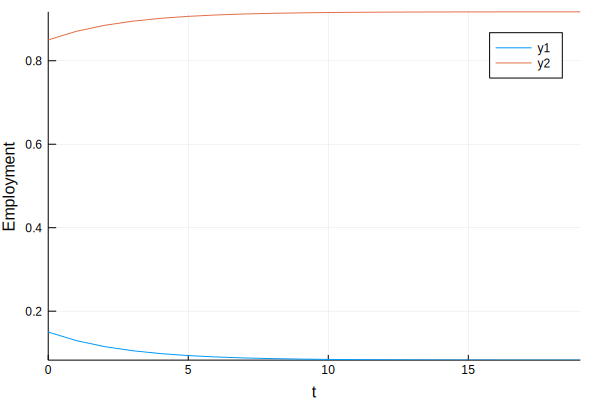

In [9]:
using Plots
lm = lm_defaults()
A, A_hat = lakemodel_transitions(lm)

#Calculate the steady state
@show xbar = rate_steady_state(A_hat)

#Simulate
x0 = [0.15; 0.85]
T= 20
@assert sum(x0) ≈ 1 #otherwise, it is not a proper pdf

rates = simulate_path(A_hat, x0, T)
plot(0:T-1, rates[1,:], xlabel="t", ylabel="Unemployment")
plot!(0:T-1, rates[2,:], xlabel="t", ylabel="Employment")

## Proportion of Time Unemployed

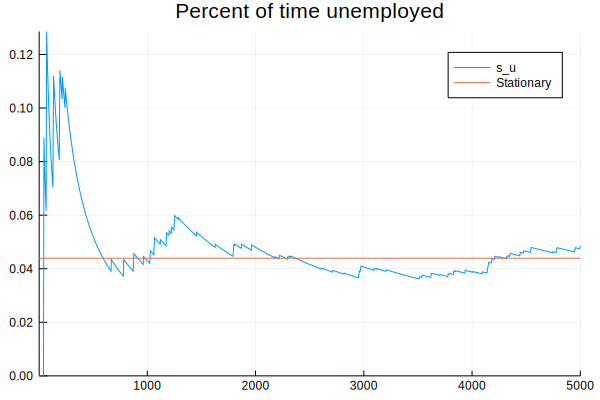

In [58]:
lm = lm_defaults(d=0.0, b=0.0) #No death or birth
T = 5000     # Simulation length

α, λ = lm.α, lm.λ
P = [(1 - λ)     λ; 
     α       (1 - α)]

mc = MarkovChain(P, [1; 2])     # 1=unemployed, 2=employed
xbar = stationary_distributions(mc)[1]

s_path = simulate(mc, T; init=2) #Start employted
s_path_u = cumsum(s_path .== 1 , 1) ./ ( 1:T)
plot(1:T, s_path_u, label="s_u", title="Percent of time unemployed")
plot!(1:T, xbar[1] * ones(1,T)', label="Stationary")

## Code to solve the McCall model
Copied from the McCall lecture

In [106]:
function solve_mccall_model(mcm; tol=1e-5, max_iter=2000, U_iv = 1.0, V_iv = ones(length(mcm.w)))
    @unpack α, β, σ, c, γ, w, p, u = mcm

    #Calculate the utility at the wages and unemployment
    u_w = u.(w, σ)
    u_c = u(c, σ)
    
    #Value function iteration
    # Setting up map T(x) -> x.  The fixed point is a x* such that T(x*) = x*
    function T(x) #Bellman operator
        V = x[1:end-1]
        U = x[end]
        return [u_w + β * ((1 - α) * V + α * U);
                u_c + β * (1 - γ) * U + β * γ * dot(max.(U, V), p)]        
    end
    
    x_iv = [V_iv; U_iv]; #Initial value to use for the fixed point
    xstar = fixedpoint(T, x_iv; tol = tol, maxiter=max_iter)    
    V = xstar[1:end-1]
    U = xstar[end]
    #Find the policy, where V > U  
    wbarindex = searchsortedfirst(V - U, 0.0)
    if(wbarindex > length(w))
        wbar = -Inf
    elseif(wbarindex > 0)
        wbar = w[wbarindex]
    else
        wbar = Inf
    end
    return V, U, wbar
end



solve_mccall_model (generic function with 1 method)

## Default Parameters for the McCall Model

In [107]:
#Wage values and distribution to use for probabilities.
using Distributions

#This discretizes a lognormal.  Must be a better example?
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
w_vec = linspace(1e-3, max_wage, wage_grid_size + 1)
logw_dist = Normal(log(log_wage_mean), 1)
cdf_logw = cdf.(logw_dist, log.(w_vec))
pdf_logw = cdf_logw[2:end] - cdf_logw[1:end-1]
p_vec = pdf_logw ./ sum(pdf_logw)
w_vec = (w_vec[1:end-1] + w_vec[2:end]) / 2

#Generator for the named tuple to hold all parameters
mcm_defaults = @with_kw(
    u = (c,σ) -> (c.^(1 - σ) - 1) / (1 - σ),
    α = 0.013,
    β = 0.98,
    γ = 1.0,
    σ = 2.0,
    w = w_vec,
    p = p_vec,
    c = 0) #Generally overwritten)

(::#286) (generic function with 1 method)

## Settings for Lake Model with Endogenous Acceptance

In [119]:
function compute_steady_state_quantities(c, τ)
    mcm = mcm_defaults(c = c - τ, w = collect(w_vec - τ))
    V, U, w_bar = solve_mccall_model(mcm)

    λ = mcm.γ * sum(p_vec[w_vec - τ .> w_bar])

#     Compute steady state employment and unemployment rates
    lm = lm_defaults(d=0.0, b=0.0, λ=λ) 
    A, A_hat = lakemodel_transitions(lm)
    x = rate_steady_state(A_hat)
    u_rate, e_rate = x

     # Compute steady state welfare
     w = sum(V .* p_vec .* (w_vec - τ .> w_bar)) / sum(p_vec .* (w_vec - τ .> w_bar))
     welfare = e_rate .* w + u_rate .* U

    return u_rate, e_rate, welfare, λ
end

compute_steady_state_quantities (generic function with 1 method)

In [ ]:
function find_balanced_budget_tax(c)
    function steady_state_budget(t::Real)
      u_rate, e_rate, w, λ = compute_steady_state_quantities(c, t)
      return t - u_rate * c
    end

    τ = brent(steady_state_budget, 0.0, 0.9 * c)

    return τ, λ
end
find_balanced_budget_tax(10)


In [ ]:
# Levels of unemployment insurance we wish to study
Nc = 60
c_vec = linspace(5.0, 140.0, Nc)

tax_vec = Vector{Float64}(Nc)
unempl_vec = Vector{Float64}(Nc)
empl_vec = Vector{Float64}(Nc)
welfare_vec = Vector{Float64}(Nc)

for i = 1:Nc
    t, λ = find_balanced_budget_tax(c_vec[i])
    u_rate, e_rate, welfare = compute_steady_state_quantities(c_vec[i], t)
    tax_vec[i] = t
    unempl_vec[i] = u_rate
    empl_vec[i] = e_rate
    welfare_vec[i] = welfare
end
@show tax_vec

# fig, axes = subplots(2, 2, figsize=(15, 10))

# plots = [unempl_vec, empl_vec, tax_vec, welfare_vec]
# titles = ["Unemployment", "Employment", "Tax", "Welfare"]

# for (ax, plot, title) in zip(axes, plots, titles)
#     ax[:plot](c_vec, plot, "b-", lw=2, alpha=0.7)
#     ax[:set](title=title)
# end

# fig[:tight_layout]()

In [29]:
lm = LakeModel()
x0 = rate_steady_state(lm)
println("Initial Steady State: $x0")

LoadError: [91mUndefVarError: LakeModel not defined[39m

```none
Initial Steady State: [0.0826681, 0.917332]
```


In [11]:
N0 = 100
T = 50

50

In [12]:
lm = LakeModel(λ = 0.2)

LakeModel{Float64}(0.2, 0.013, 0.0124, 0.00822, 0.00418, [0.805824 0.0252931; 0.198356 0.978887], [0.80247 0.0251879; 0.19753 0.974812])

```none
LakeModel{Float64}(0.2, 0.013, 0.0124, 0.00822, 0.00418, [0.805824 0.0252931; 0.198356 0.978887], [0.80247 0.0251879; 0.19753 0.974812])
```


In [13]:
xbar = rate_steady_state(lm) # new steady state
X_path = simulate_stock_path(lm,x0 * N0, T)
x_path = simulate_rate_path(lm,x0, T)
println("New Steady State: $xbar")

LoadError: [91mUndefVarError: TF not defined[39m

```none
New Steady State: [0.113096, 0.886904]
```


In [14]:
titles = ["Unemployment" "Employment" "Labor force"]

x1 = X_path[1, :]
x2 = X_path[2, :]
x3 = squeeze(sum(X_path, 1), 1)

fig, axes = subplots(3, 1, figsize=(10, 8))

for (ax, x, title) in zip(axes, [x1, x2, x3], titles)
    ax[:plot](1:T, x, c="blue")
    ax[:set](title=title)
end

fig[:tight_layout]()

LoadError: [91mUndefVarError: X_path not defined[39m

In [15]:
titles = ["Unemployment rate" "Employment rate"]

fig, axes = subplots(2, 1, figsize=(10, 8))

for (i, ax) in enumerate(axes)
    ax[:plot](1:T, x_path[i, :], c="blue", lw=2, alpha=0.5)
    ax[:hlines](xbar[i], 0, T, "r", "--")
    ax[:set](title=titles[i])
end

LoadError: [91mUndefVarError: subplots not defined[39m

In [16]:
lm = LakeModel()
x0 = rate_steady_state(lm)

2-element Array{Float64,1}:
 0.0826681
 0.917332 

```none
2-element Array{Float64,1}:
 0.0826681
 0.917332
```


In [17]:
b_hat = 0.003
T_hat = 20

20

In [18]:
lm = LakeModel(b=b_hat)
X_path1 = simulate_stock_path(lm,x0 * N0, T_hat) # simulate stocks
x_path1 = simulate_rate_path(lm,x0, T_hat) # simulate rates

LoadError: [91mUndefVarError: TF not defined[39m

```none
2×20 Array{Float64,2}:
 0.0826681  0.0739993  0.067915  …  0.0536612  0.0536401  0.0536253
 0.917332   0.926001   0.932085     0.946339   0.94636    0.946375
```


In [19]:
lm = LakeModel(b=0.0124)
X_path2 = simulate_stock_path(lm, X_path1[:, end-1], T-T_hat+1) # simulate stocks
x_path2 = simulate_rate_path(lm, x_path1[:, end-1], T-T_hat+1) # simulate rates

LoadError: [91mUndefVarError: X_path1 not defined[39m

```none
2×31 Array{Float64,2}:
 0.0536401  0.0624842  0.0686335  …  0.0826652  0.0826655  0.0826657
 0.94636    0.937516   0.931366      0.917335   0.917335   0.917334
```


In [20]:
x_path = hcat(x_path1, x_path2[:, 2:end]) # note [2:] to avoid doubling period 20
X_path = hcat(X_path1, X_path2[:, 2:end])

LoadError: [91mUndefVarError: x_path1 not defined[39m

```none
2×50 Array{Float64,2}:
 8.26681   7.36131   6.72078   6.2653  …   8.45538   8.49076   8.52628
 91.7332   92.1167   92.2379   92.1769     93.8293   94.2215   94.6153
```


In [21]:
titles = ["Unemployment" "Employment" "Labor force"]

x1 = X_path[1,:]
x2 = X_path[2,:]
x3 = squeeze(sum(X_path, 1), 1)

fig, axes = subplots(3, 1, figsize=(10, 9))

for (ax, x, title) in zip(axes, [x1, x2, x3], titles)
    ax[:plot](1:T, x, "b-", lw=2, alpha=0.7)
    ax[:set](title=title, ylim=(minimum(x-1), maximum(x+1)))
end

fig[:tight_layout]()

LoadError: [91mUndefVarError: X_path not defined[39m

In [22]:
titles = ["Unemployment Rate" "Employment Rate"]

fig, axes = subplots(2, 1, figsize=(10, 8))

for (i, ax) in enumerate(axes)
    ax[:plot](1:T, x_path[i, :], "-b", lw=2, alpha=0.7)
    ax[:hlines](x0[i], 0, T, "r", "--")
    ax[:set](title=titles[i])
end

LoadError: [91mUndefVarError: subplots not defined[39m